# Sensitivity Analysis of the solution of the diffusion equation

In [1]:
import numpy as np
from scipy.special import erf
import math
import matplotlib.pyplot as plt

### Mathematical Model
Here we analyze the solution of the diffusion equation PDE under step change in concentration boundary conditions.

Note that the concentration terms were replaced by 1 and $C_r$. $C_r$ is the ratio between the methane concentration in the caprock and the methane concentration in the reservoir. In order to have methane diffusive intrution $C_r$ should vary between 0 and 1.

$$
C(z,t) = \left[1-erf\left(\frac{z}{2\sqrt{Dt}}\right)\right](C_{res}-C_{cap})+C_{cap}
$$

$$
\frac{C(z,t)}{C_{res}} = \left[1-erf\left(\frac{z}{2\sqrt{Dt}}\right)\right](1-\frac{C_{cap}}{C_{res}})+\frac{C_{cap}}{C_{res}}
$$

In [5]:
def model(Cr, D, t, z):
    t = t*1000000*365*86400
    C = (1-erf(z/(2*math.sqrt(D*t))))*(1-Cr)+Cr
    return C

### Variables and Parameters definition
Here we define the range of variability for $C_r$, the diffusion coefficient $D$, and the intrution time $t$. In addition we define the "depth" of analysis $Z$.

Also we define the pdf of the model parameters and randomly sample from the distribution to generate sets of stochastic points.

In [3]:
Z = np.linspace(0,200,201)
n_samples = 10000
param_list = ['Cr', 'D', 't']
Npar = len(param_list)
Cr_all = np.random.uniform(0.01, 0.2, n_samples)
D_all = np.random.uniform(1E-11, 1E-9, n_samples)
t_all = np.random.uniform(0.2, 20, n_samples)
param_array = np.array((Cr_all, D_all, t_all))

### Model evaluation
Here we evaluate the model output $C_{out}(z)$ for all the combinations of points defined in the previous section.

In [6]:
C_out = np.zeros((n_samples, len(Z)))
for i in range(n_samples):
    C_out[i,:] = model(Cr_all[i], D_all[i], t_all[i], Z)

We can plot the results to have an idea of the type of results that we are obtaining.

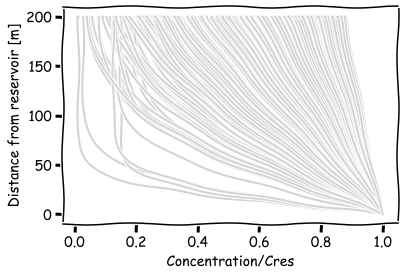

In [9]:
with plt.xkcd():
    for i in range(n_samples):
        if i > 1000:
            break
        plt.plot(C_out[i,:], Z, color = 'lightgray')
    plt.xlabel('Concentration/Cres')
    plt.ylabel('Distance from reservoir [m]')
    plt.show()

Here we select a particular depth to perform the sensitivity analysis

In [10]:
z = 100
Results = C_out[:,z+1]

In [11]:
nclass = 10

cond_mean = np.zeros((Npar,nclass))
cond_var = np.zeros((Npar,nclass))

AMAE = np.zeros(Npar)
AMAV = np.zeros(Npar)
Si = np.zeros(Npar)

In [12]:
for ipar,item_par in enumerate (param_list):
    par_rand_values = param_array[ipar,:]
    par_min = par_rand_values.min()
    par_max = par_rand_values.max()
    discret = (par_max-par_min)/nclass

    for iclass in range (0,nclass):
        output_class = (Results[(par_rand_values<par_min+discret*(iclass+1)) & (par_rand_values>par_min+discret*iclass)])

        cond_mean[ipar,iclass]=np.mean(output_class)
        cond_var[ipar,iclass]=np.var(output_class)

    Si[ipar]=(np.var(cond_mean[ipar,:],ddof=1))/np.var(Results)
    AMAE[ipar]=np.mean(abs(cond_mean[ipar,:]-np.mean(Results)))/abs(np.mean(Results))
    AMAV[ipar]=np.mean(abs(cond_var[ipar,:]-np.var(Results)))/abs(np.var(Results))

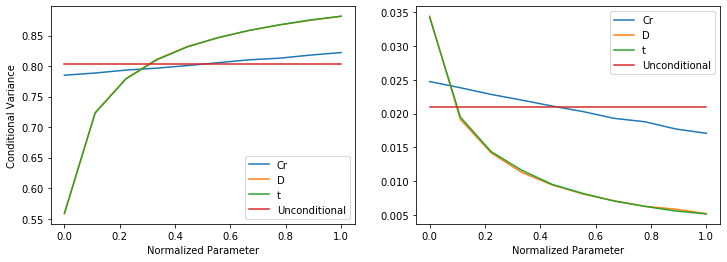

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
for i in range(Npar):
    ax[0].plot(np.linspace(0,1,nclass), cond_mean[i,:], label = param_list[i])
    ax[1].plot(np.linspace(0,1,nclass), cond_var[i,:], label = param_list[i])
ax[0].plot(np.linspace(0,1,nclass), np.ones(nclass)*np.mean(Results), label = 'Unconditional')
ax[1].plot(np.linspace(0,1,nclass), np.ones(nclass)*np.var(Results), label = 'Unconditional')
ax[0].set_xlabel('Normalized Parameter')
ax[1].set_xlabel('Normalized Parameter')
ax[0].set_ylabel('Conditional Mean')
ax[0].set_ylabel('Conditional Variance')
ax[0].legend()
ax[1].legend()
plt.show()

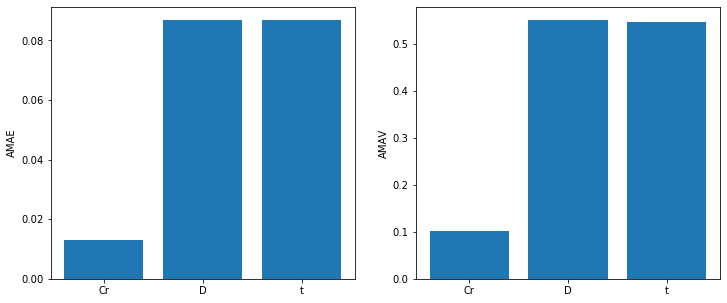

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].bar(param_list, AMAE)
ax[1].bar(param_list, AMAV)

ax[0].set_ylabel('AMAE')
ax[1].set_ylabel('AMAV')
plt.show()